<center><h1 style="background-color:white; color:blue; font-size:40px; font-weight:bold; font-family:Times New Roman;" >Tony Kao A/B Testing Example</h1></center>

# Business Statistics: E-news Express

## Define Problem Statement and Objectives

Objective and Problem Statement: As a Data Scientist for E-News Express, conduct A/B testing on the landing page. Determine which landing page, existing (Control) vs new (Treatment) leads to higher rate of subscriptions by randomly sampling 100 users and dividing them into two equally sized groups. Explore the data and perform a statistical analysis (at a significance level of 5%) to determine the effectiveness of the new landing page in gathering new subscribers for the news portal.

Determine:


1. Do the users spend more time on the new landing page than on the existing landing page?
2. Is the conversion rate (the proportion of users who visit the landing page and get converted) for the new page greater than the conversion rate for the old page?
3. Does the converted status depend on the preferred language?
4. Is the time spent on the new page the same for the different language users?


### Data Dictionary

The data contains information regarding the interaction of users in both groups with the two versions of the landing page.

    user_id - Unique user ID of the person visiting the website
    group - Whether the user belongs to the first group (control) or the second group (treatment)
    landing_page - Whether the landing page is new or old
    time_spent_on_the_page - Time (in minutes) spent by the user on the landing page
    converted - Whether the user gets converted to a subscriber of the news portal or not
    language_preferred - Language chosen by the user to view the landing page


### Import all the necessary libraries

In [1]:
# Import needed libraries

%load_ext lab_black

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

### Data Overview

In [2]:
# Read from CSV
df = pd.read_csv("abtest.csv")

In [3]:
# First 5 rows
df.head()

,user_id,group,landing_page,time_spent_on_the_page,converted,language_preferred
0,546592,control,old,3.48,no,Spanish
1,546468,treatment,new,7.13,yes,English
2,546462,treatment,new,4.40,no,Spanish
3,546567,control,old,3.02,no,French
4,546459,treatment,new,4.75,yes,Spanish


In [4]:
# Last 5 rows
df.tail()

,user_id,group,landing_page,time_spent_on_the_page,converted,language_preferred
95,546446,treatment,new,5.15,no,Spanish
96,546544,control,old,6.52,yes,English
97,546472,treatment,new,7.07,yes,Spanish
98,546481,treatment,new,6.20,yes,Spanish
99,546483,treatment,new,5.86,yes,English


In [5]:
# Data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 100 non-null    int64  
 1   group                   100 non-null    object 
 2   landing_page            100 non-null    object 
 3   time_spent_on_the_page  100 non-null    float64
 4   converted               100 non-null    object 
 5   language_preferred      100 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 4.8+ KB


In [6]:
# Statistical summary of the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,100.0,546517.0000,52.295779,546443.00,546467.75,546492.500,546567.2500,546592.00
time_spent_on_the_page,100.0,5.3778,2.378166,0.19,3.88,5.415,7.0225,10.71


In [7]:
# Check for missing values
df.isnull().sum()

user_id                   0
group                     0
landing_page              0
time_spent_on_the_page    0
converted                 0
language_preferred        0
dtype: int64

In [8]:
# Check for duplicated values
df[df.duplicated()]

,user_id,group,landing_page,time_spent_on_the_page,converted,language_preferred


**Data Overview Summary:** Overall data is as expected. User_ID is not relevant to the analysis, so we'll need to exclude this moving forward. Luckily this dataset does not have any missing values or duplicated values, but if it did, we would need to make assumptions and fill with median values, or some other approach.

### Exploratory Data Analysis

**Univariate Analysis**

In [9]:
# Function to create histrogram/boxplots


def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [10]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

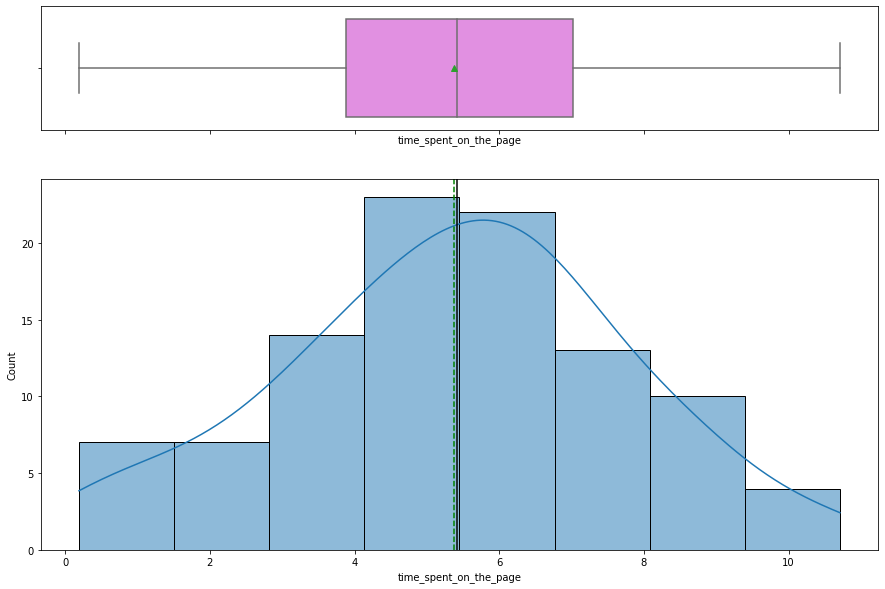

In [11]:
# Histogram boxplot of time spent on the page
histogram_boxplot(df, "time_spent_on_the_page", kde=True)

#### We can infer this is normal distribution ####

#### **Preferred Language** 

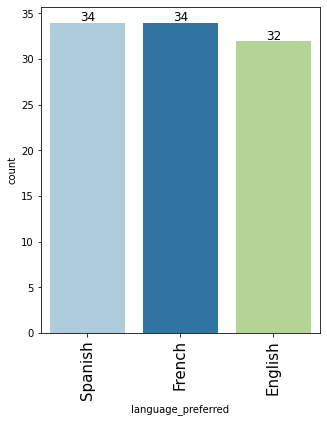

In [12]:
# Labeled Barplot of preferred language
labeled_barplot(df, "language_preferred")

#### **Converted** 

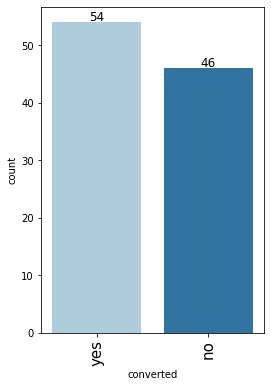

In [13]:
# Labeled barplot of converted - Whether a user gets the new page or not
labeled_barplot(df, "converted")

**Bivariate Analysis**

In [14]:
# function to plot distributions wrt target


def distribution_plot_wrt_target(data, predictor, target):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

In [15]:
# Function to create a stocked barplot


def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left",
        frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

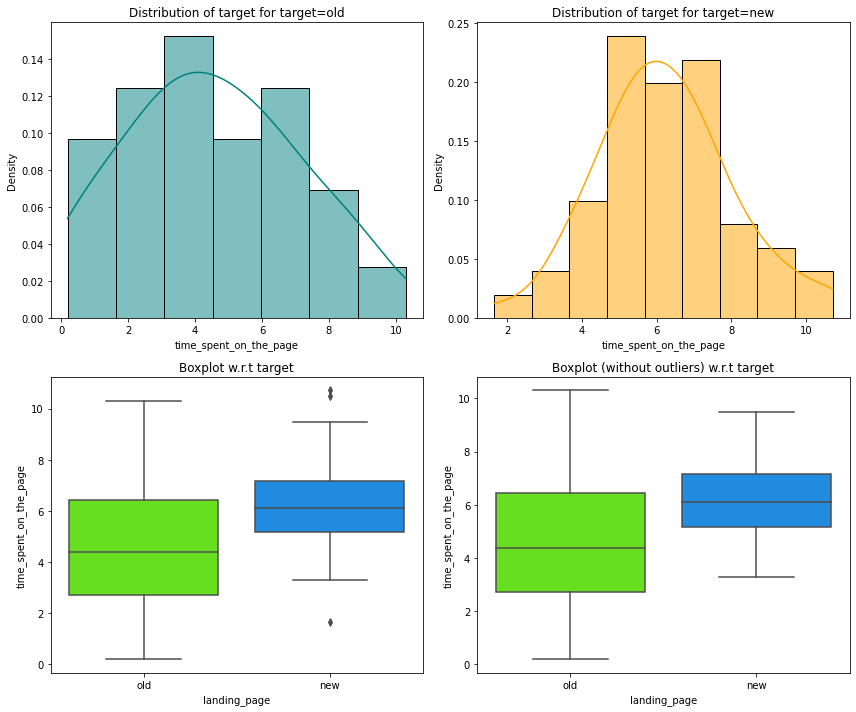

In [16]:
# Distributions of time spent on the page for old, and new pages, as well as distributions
distribution_plot_wrt_target(df, "time_spent_on_the_page", "landing_page")

converted           no  yes  All
language_preferred              
All                 46   54  100
French              19   15   34
Spanish             16   18   34
English             11   21   32
------------------------------------------------------------------------------------------------------------------------


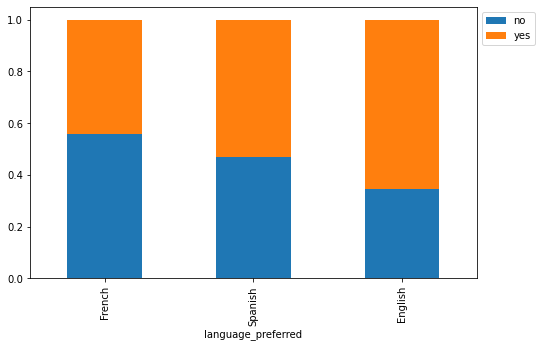

In [17]:
# Stacked barplot of preferred language vs converted
stacked_barplot(df, "language_preferred", "converted")

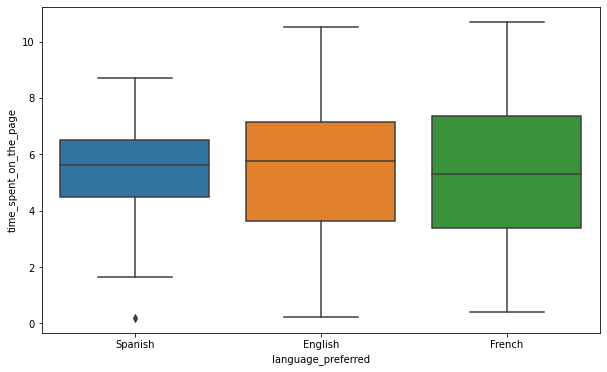

In [18]:
# Box plots of preferred language and time on the page.
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y="time_spent_on_the_page", x="language_preferred")
plt.show()

### **Q1.** Do the users spend more time on the new landing page than the existing landing page?

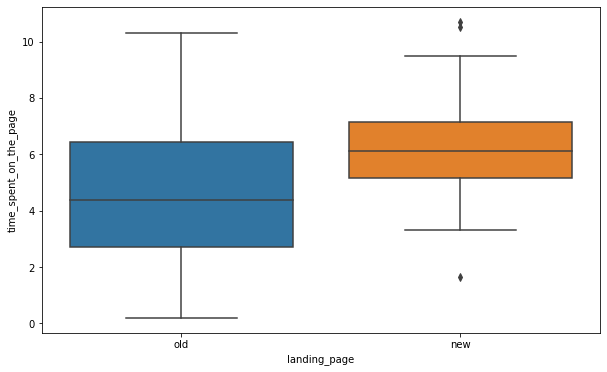

In [19]:
# Box plots of preferred language and time on the page.
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y="time_spent_on_the_page", x="landing_page")
plt.show()

$H_0$: The null hypothesis is that the mean time spent on the new page, represented as $\mu_1$ is the same as the mean time spend on the old page, represented as $\mu_2$
<center>$H_0$ : $\mu_1$  =  $\mu_2$</center>


$H_a$: The alternate hypothesis is that the mean time spent on the new page, represented as $\mu_1$ is less than the mean time spend on the old page, represented as $\mu_2$
<center>$H_a$ : $\mu_1$ $\gt$ $\mu_2$</center>

Knowns:
* Univariate
* Continous and Normal
* 2 Samples (Independent)
* Unknown Variance

We can use a **2-Sample T-Test**

For this question, we use a level of significance of 5%

In [20]:
# Create two subsets of data based on landing page to determine standard deviation
time_spent_new = df[df["landing_page"] == "new"]
time_spent_old = df[df["landing_page"] == "old"]

print(
    "New page Standard Deviation:",
    round(time_spent_new["time_spent_on_the_page"].std(), 2),
)
print(
    "Old page Standard Deviation:",
    round(time_spent_old["time_spent_on_the_page"].std(), 2),
)

New page Standard Deviation: 1.82
Old page Standard Deviation: 2.58


**Observation:** The sample standard deviations are not close to being equal, therefore we cannot assume the population standard deviation is equal

In [21]:
# Calculate the P-Value
from scipy.stats import ttest_ind

test_stat, p_value = ttest_ind(
    time_spent_new["time_spent_on_the_page"],
    time_spent_old["time_spent_on_the_page"],
    equal_var=False,
    alternative="greater",
)

print("p-value:", p_value)

p-value: 0.00013923812251665497


**Observation:** As the p-value (~0.00013) is less than the level of significance, we can **reject** the null hypothesis. Hence, we do have enough evidence to support the claim that the time spent on the new landing page is greater than the time spent on the old landing page.

### **Q2.** Is the conversion rate (the proportion of users who visit the landing page and get converted) for the new page greater than the conversion rate for the old page?

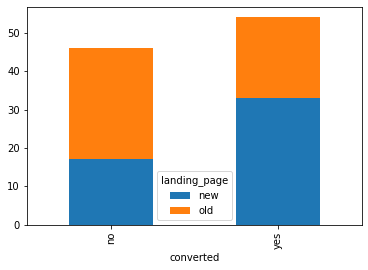

In [22]:
# Create contingency table and graph
Q2_contingency_table = pd.crosstab(df["converted"], df["landing_page"])
Q2_contingency_table.plot(kind="bar", stacked=True)
plt.show()

$H_0$: The null hypothesis is that the proportion of users that get converted to subscribers that visit the the new page, represented as $p_1$ is the same as the proportion of users that get converted to subscribers that visit the the old page, represented as $p_2$
<center>$H_0$ : $p_1$  =  $p_2$</center>


$H_a$: The alternate hypothesis is that the proportion of users that get converted to subscribers that visit the the new page, represented as $p_1$ is greater than the proportion of users that get converted to subscribers that visit the the old page, represented as $p_2$
<center>$H_a$ : $p_1$ $\gt$ $p_2$</center>

Knowns:
* Univariate
* Discrete
* 2 Samples

Following the flow chart, we can use a **Two Proportion Z-test**

For this question, we use a level of significance of 5%

In [23]:
# Create new dataframes of treatment and control for counts. Needed later for p=value calculation and ensuring groups are larger than 10.
df_new = df[df["group"] == "treatment"]
df_old = df[df["group"] == "control"]

new_converted = df[df["group"] == "treatment"]["converted"].value_counts()["yes"]
old_converted = df[df["group"] == "control"]["converted"].value_counts()["yes"]

print(
    f"Total New Page: {df_new.shape[0]} - New Page Converted: {new_converted} | Total Old Page: {df_old.shape[0]} - Old Page Converted: {old_converted}"
)

Total New Page: 50 - New Page Converted: 33 | Total Old Page: 50 - Old Page Converted: 21


**Observation:** All groups are greater than 10. 

In [24]:
from statsmodels.stats.proportion import proportions_ztest

# Create set of lists for p-value calc
converted = [new_converted, old_converted]
total = [df_new.shape[0], df_old.shape[0]]

test_stat, p_value = proportions_ztest(converted, total, alternative="larger")

print("p-value:", p_value)

p-value: 0.008026308204056278


**Observation:** As the p-value (~0.008) is less than the level of significance, we can **reject** the null hypothesis. Hence, we do have enough evidence to support the claim that the conversion rate (the proportion of users who visit the landing page and get converted) for the new page greater than the conversion rate for the old page.

### **Q3.** Is the conversion and preferred language are independent or related?

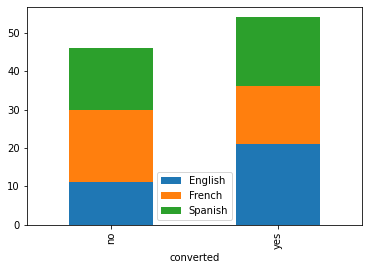

In [25]:
# Create contingency table and graph
Q3_contingency_table = pd.crosstab(df["converted"], df["language_preferred"])
Q3_contingency_table.plot(kind="bar", stacked=True)
plt.legend()
plt.show()

$H_0$: The null hypothesis is that conversion rate independent of language preferred.


$H_a$: The alternate hypothesis is that conversion rate is dependent of language preferred.

Knowns:
* Bivariate
* Both discrete

Following the flow chart, we can use a **Chi Square test**

For this question, we use a level of significance of 5%

In [26]:
# Data previously prepared for visual analysis.
Q3_contingency_table

language_preferred,English,French,Spanish
converted,,,
no,11,19,16
yes,21,15,18


In [27]:
from scipy.stats import chi2_contingency

chi2, p_value, dof, exp_freq = chi2_contingency(Q3_contingency_table)
print("p-value:", p_value)

p-value: 0.21298887487543447


**Observation:** As the p-value (~0.2129) is greater than the level of significance, we **fail to reject** the null hypothesis. Hence, we do not have enough evidence to support the claim that the conversion rate and preferred language are related.

### **Q4.** Is the time spent on the new page same for the different language users?

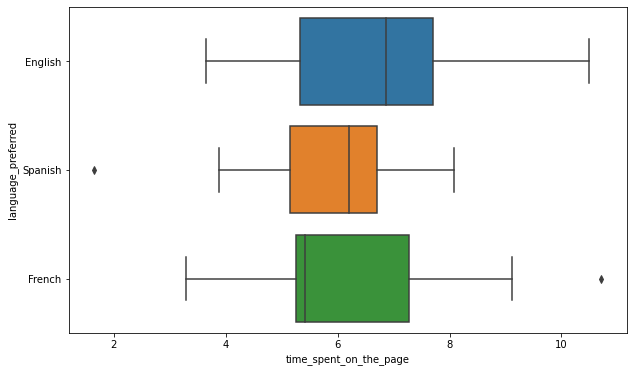

In [28]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_new, x="time_spent_on_the_page", y="language_preferred")
plt.show()

$H_0$: The null hypothesis is that the population mean of time spent on the new page is the same for English (represented as $\mu_1$), Spanish (represented as $\mu_2$), and French (represented as $\mu_3$)
<center>$H_0$ : $\mu_1$  =  $\mu_2$ = $\mu_3$</center>


$H_a$: The alternate hypothesis is that is that at least one mean time spent on the new page is different than the rest.

Knowns:
* Univariate
* Continuous and Normal
* 2 Samples

Following the flow chart, we can use a **One-way Anova F-Test (levene Test)**

For this question, we'll use a level of significance of 5%

In [29]:
# Create dataframes required for p-value test
English_time = df_new[df_new["language_preferred"] == "English"][
    "time_spent_on_the_page"
]
Spanish_time = df_new[df_new["language_preferred"] == "Spanish"][
    "time_spent_on_the_page"
]
French_time = df_new[df_new["language_preferred"] == "French"]["time_spent_on_the_page"]

In [30]:
from scipy.stats import levene

test_stat, p_value = levene(English_time, Spanish_time, French_time)

print("p-value:", p_value)

p-value: 0.46711357711340173


**Observation:** As the p-value (~0.467) is greater than the level of significance, we **fail to reject** the null hypothesis. Hence, we do not have enough evidence to support the claim that mean time spent on the new page is different, for different language users.

## Conclusion and Business Recommendations

### **Conclusion** ###

The results of the A/B Test show that the new landing page redesign was successful, as we were able to **reject** the null hypothesis for questions #1 and #2 and **fail to reject** the null hypothesis for questions #3 and #4:

1. Do the users spend more time on the new landing page than on the existing landing page? **Yes**
2. Is the conversion rate (the proportion of users who visit the landing page and get converted) for the new page greater than the conversion rate for the old page? **Yes**
3. Does the converted status depend on the preferred language? **No**
4. Is the time spent on the new page the same for the different language users? **The same**

### **Business Recommendations** ###

Moving forward, based results on A/B testing, my recommendation to E-News Express would be to explore ways to increase time spent on the landing page. We've proven that language does not play a part in conversion rate, however, we do a see a relationship in the new page increasing time spent on the landing page, and an increase in conversion rate for the new page, therefore **we can infer that increasing time spent on the landing page can lead to increased subscriber conversion**.

___